In [330]:
!git add 01_velib.ipynb

In [367]:
!git commit -m "très bien"

[refaire_cycliste 993850d] tr��s bien
 1 file changed, 929 insertions(+), 112 deletions(-)


In [591]:
!git checkout -b "refaire_cycliste"

fatal: A branch named 'refaire_cycliste' already exists.


In [368]:
!git push 

Counting objects: 3, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 38.48 KiB | 3.85 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/romainjouin/formation_python
   2b4211f..993850d  refaire_cycliste -> refaire_cycliste


# Debut

In [1]:
def compare_positions(p1,p2):
    """
    
    """
    test1 = p1.longitude==p2.longitude 
    test2 = p1.lattitude==p2.lattitude 
    return test1 and test2    


In [2]:
def random_float(min=0, max=9):
    import random
    entier = random.randint(min, max)
    float_ = random.random()
    return entier+float_

In [3]:
class Position():
    def __init__(self, longitude, lattitude):
        self.longitude = longitude
        self.lattitude = lattitude
    def __str__(self):
        return "(lon:%.2f lat:%.2f)"%(self.longitude, self.lattitude)


# 1) Logger

In [4]:
class Logger():
    def __init__(self, path, bufferlength=1, separator="\n", mode="a"):
        import os
        if os.path.exists(path) :
            msg = "Attention : vous allez utiliser un fichier existant !"
            print (msg)
            if (mode != "a"):
                raise msg
        self.path         = path
        self.logs         = []
        self.bufferlength = bufferlength
        self.separator    = separator

    def clean_msg(self, msg):
        msg = str(msg)
        if msg[-1] != "\n": 
            msg = msg + "\n"
        return msg
    
    def log(self, msg):
        msg = self.clean_msg(msg)
        import datetime
        msg=str(datetime.datetime.now().isoformat())+","+msg
        self.logs.append(msg)
        if self.bufferlength < len(self.logs):
            self.write_to_disk()
    
    def write_to_disk(self):
        import codecs
        with codecs.open(self.path, "a", "utf-8-sig") as f:
            f.writelines(self.logs)
        self.logs= []
    
    def __del__(self):
        self.write_to_disk()
                

In [5]:
def get_random_position(x_max, y_max):
    return Position(random_float(0, y_max), random_float(0, y_max))

# 2) Velo

In [6]:
class Velo:
    nb_d_instance =0
    def __init__(self):
        import random
        Velo.nb_d_instance += 1
        self.id             = "velo_%s"%(Velo.nb_d_instance)
        self.performance    = random.random()
    def update_performance(self):
        import numpy as np
        self.performance = np.random.normal(0.75, 0.2)
    def __str__(self):
        return "%s : perf = %.2f"%(self.id, self.performance)

# Velo - test

In [7]:
def test_velo():
    v = Velo()
    perfs = [(v.update_performance(), v.performance)[1] for x in range(10)]
    print(perfs)
test_velo()

[0.9822150037207311, 1.23536529601897, 0.4674074618767033, 1.1984560641108353, 0.5001031048452125, 0.5426157502490723, 0.9089657641000333, 0.6895626962176244, 0.7603950298291292, 0.8249703164892881]


# 3) Trajet

In [8]:
class Trajet():
    nb_d_instance =0
    trajet_logger= Logger("./trajets.csv")
    def __init__(self, position_depart, position_arrivee):
        Trajet.nb_d_instance +=1
        self.id          = Trajet.nb_d_instance
        self.depart      = position_depart
        self.destination = position_arrivee
        self.set_position(position_depart)
        self.set_distance() 
        self.avancee_minimale = 0.1
        self.log("Creation : %s -> %s (d=%s)"%(self.depart, self.destination, self.distance))
    def __str__(self):
        return "%s -> %s"%(self.depart, self.destination)
    
    def log(self, message):
        message="trajet_%s : %s"%(self.id, message)
        Trajet.trajet_logger.log(message)
        
    def set_position(self, position):
        self.longitude   = position.longitude
        self.lattitude   = position.lattitude
        self.position    = position
        self.log("New position : %s "%(self.position))
        
    def set_distance(self):
        import math
        delta_longitude = self.destination.longitude  - self.longitude
        delta_lattitude = self.destination.lattitude  - self.lattitude
        distance        = math.sqrt(math.pow(delta_longitude, 2) + math.pow(delta_lattitude, 2))
        self.distance   = distance
        #print("distance =" + str(distance))
        self.log("distance : %s "%(self.distance))        
        
    def next_position(self, km_h=10):
        self.set_distance() 
        if self.distance < self.avancee_minimale:
            self.set_position(self.destination)
            self.log("self.distance < self.avancee_minimale -> new position: %s "%(self.position))                    
            return self.destination
        import math
        depart        = self.position
        arrivee       = self.destination
        sur_abscisse  = abs(arrivee.longitude - depart.longitude)
        sur_ordonnees = abs(arrivee.lattitude - depart.lattitude)
        hypothenuse   = math.sqrt(sur_abscisse**2 +sur_ordonnees**2 )
        cosinus       = sur_abscisse / hypothenuse if hypothenuse!=0 else 0
        sinus         = sur_ordonnees/hypothenuse if hypothenuse!=0 else 0
        parcours      = km_h / 60
        #print("parcours = %s"%parcours)
        
        if depart.longitude < arrivee.longitude:
            new_abscisse  = depart.longitude + (cosinus * parcours)
        else:
            new_abscisse  = depart.longitude - (cosinus * parcours)
            
        if depart.lattitude > arrivee.lattitude:
            new_ordonnees = depart.lattitude - (sinus * parcours)
        else:
            new_ordonnees = depart.lattitude + (sinus * parcours)
        
        new_position  = Position(new_abscisse, new_ordonnees)
        
        self.set_position(new_position)
        self.log("new position: %s "%(self.position))                    
        #self.set_distance()
        
        if self.distance < parcours:
            self.set_position(self.destination)
            self.log("self.distance < parcours -> new position: %s "%(self.position))                    
            return self.destination
        else:
            return new_position

Attention : vous allez utiliser un fichier existant !


In [9]:
def test_trajet():
    # de 0,0 a 0,0
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=0,lattitude=0)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    assert (t.distance==0)
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==0)
    assert (t.pas_lattitude==0)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
    
    # de 0,0 a 0,1
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=0,lattitude=1)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    assert (t.distance==1)
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==0)
    #assert (t.pas_lattitude==1/3)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
    
    # de 0,0 a 1,1
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=1,lattitude=1)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    import math
    assert (t.distance==math.sqrt(2))
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==1/3)
    assert (t.pas_lattitude==1/3)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
    
    # de 0,0 a 1,2
    depart = Position(longitude =0,lattitude=0)
    arrivee = Position(longitude=1,lattitude=2)
    t = Trajet(depart, arrivee)
    assert (t.depart==depart)
    assert (t.destination==arrivee)
    import math
    assert (t.distance==math.sqrt(2*2+1*1))
    print(t.pas_longitude)
    print(t.pas_lattitude)
    assert (t.pas_longitude==1/3)
    assert (t.pas_lattitude==1/3*2)
    print([(t.next_position(), "%s"%t.position)[1] for x in range(4)])
test_trajet()
    

AttributeError: 'Trajet' object has no attribute 'pas_longitude'

# 4) Station

In [10]:
class Station:
    nb_d_instance =0
    station_logger=Logger("./stations.csv")
    def __init__(self, position):
        import random
        Station.nb_d_instance +=1
        NB_BORNES_POSSIBLES = [5,10,15,20,30]
        self.position       = position
        self.nb_bornes      = random.choice(NB_BORNES_POSSIBLES)
        self.velos          = [Velo() for i in range(self.nb_bornes-3)]
        self.id             = Station.nb_d_instance
    def __str__(self):
        to_print = "Station n° {nom} : {position}, {nb_bornes} bornes, {nb_velos_dispo} velos"
        
        return to_print.format(nom=self.id,
                               position=self.position,
                              nb_bornes=self.nb_bornes,
                              nb_velos_dispo=len(self.velos))
    def nb_de_velos(self):
        return len(self.velos)

    def has_empty_place(self):
        return len(self.velos) < self.nb_bornes

    def has_velo(self):
        return 0 < len(self.velos)
    def log(self, message):
        message="station_%s : %s"%(self.id, message)
        Station.station_logger.log(message)
        
    def deposer_un_velo(self, velo):
        if self.has_empty_place():
            velo.update_performance()
            self.velos.append(velo)
            self.log("recupere le velo %s"%velo.id)
            return True
        else:
            self.log("complete")
            return False
    def prendre_un_velo(self, sauf=[]):
        ne_pas_prendre    = set(sauf)
        ici_interdits     = set(self.velos).intersection(ne_pas_prendre)
        present_possibles = set(self.velos).difference(ne_pas_prendre)
        if self.has_velo() and len(present_possibles):
            velo = present_possibles.pop()
            self.velos = list(present_possibles.union(ici_interdits))
            self.log("donne le velo %s"%velo.id)
            return velo
        else:
            self.log("vide.")
            return False

    def nb_velo_under_perf(self, seuil_de_performance=0.5):
        test = lambda velo: velo.performance < seuil_de_performance
        return len(list(filter(test, self.velos)))
        

Attention : vous allez utiliser un fichier existant !


# 5) Prestataire

In [11]:
class Prestataire():
    def __init__(self, largeur=10, hauteur=10):
        self.largeur = largeur
        self.hauteur = hauteur
        self.lattitude_max = hauteur
        self.longitude_max = largeur
        self.reseau = []
        for lattitude in range(self.hauteur):
            for longitude in range(self.largeur):
                emplacement = Position(lattitude, longitude)
                new_station = Station(emplacement)
                self.reseau.append(new_station)
                
    def get_closest_station(self, position):
        """
        @Todo : améliorer pour les valeurs en dehors du réseau
        """

        nb_ligne = round(position.longitude)
        nb_col   = round(position.lattitude)
        indice   =  (nb_ligne * self.largeur) + (nb_col )
        if nb_ligne<0 or nb_col<0:
            return self.reseau[0]
        
        try:
            closest  = self.reseau[int(indice)]
        except:
            closest  = self.reseau[-1]
        return closest
    

    def filtrer_le_reseau(self, function_de_test):
        """
        Renvoie les stations qui passe le test.
        
        Parameters:
            function de test : lambda function
        Return:
            list
        
        """
        return list(filter(function_de_test, self.reseau))
    def nb_station_passant_le_test(self, function):
        r = self.filtrer_le_reseau(function)
        return len(r)
    
    def nombre_de_stations(self):
        return len(self.reseau)
    
    def nombre_de_velos(self):
        return sum(map(lambda x: x.nb_de_velos(),self.reseau))
    
    def nombre_de_stations_pleine(self):
        test  = lambda station: station.nb_bornes == len(station.velos)
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_avec_velo(self):
        test = lambda x: x.has_velo()
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_vide(self):
        test  = lambda station: not station.has_velo()
        return self.nb_station_passant_le_test(test)

    def __str__(self):
        return """
                Nb de stations           : %s 
                Nb de vélos              : %s 
                Nb de stations avec vélo : %s 
                Nb de stations pleines   : %s
                Nb de stations vides     : %s
        """%(self.nombre_de_stations(),
             self.nombre_de_velos(),
             self.nombre_de_stations_avec_velo(),
             self.nombre_de_stations_pleine(),
             self.nombre_de_stations_vide())
    
    def nombre_de_velos_sous_performants(self, seuil=0.5):
        r = map(lambda station: station.nb_velo_under_perf(seuil), self.reseau)
        return sum(list(r))
    def get_topology(self):
        """
        Return a Datframe of longitude/lattitude
        """
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.reseau]}
        
        return pd.DataFrame(infos)
        
        
    

# 4.1) Test decaux

In [12]:
def test_prestataire():
    p = Prestataire(largeur=10, hauteur=10)
    point_minusOne_minusOne = Position(-1,-1)
    point_zero_zero = Position(0,0)
    point_un_un     = Position(1,1)
    point_zero5_zero5     = Position(0.5,0.5)
    point_zero6_zero6     = Position(0.6,0.6)
    point_2_4_3_2     = Position(longitude=2.4,lattitude=3.2)
    point_2_3     = Position(longitude=2,lattitude=3)
    point_9_9     = Position(longitude=9,lattitude=9)
    point_10_10     = Position(longitude=10,lattitude=10)
    print(p.get_closest_station(point_zero_zero).position==Position(0,0))
    assert(compare_positions(point_zero_zero, p.get_closest_station(point_zero_zero).position))
    assert(compare_positions(point_un_un, p.get_closest_station(point_un_un).position))
    assert(compare_positions(point_zero_zero, p.get_closest_station(point_zero5_zero5).position   ))
    assert(compare_positions(point_un_un, p.get_closest_station(point_zero6_zero6).position   ))
    assert(compare_positions(point_2_3, p.get_closest_station(point_2_4_3_2).position       ))
    print(p.get_closest_station(point_10_10).position)
    assert(compare_positions(point_9_9, p.get_closest_station(point_10_10).position       ))    
    assert(compare_positions(point_zero_zero, p.get_closest_station(point_minusOne_minusOne).position       ))        
test_prestataire()

False
(lon:9.00 lat:9.00)


In [201]:
def draw(positions, ax=False, color="blue"):
    """
    Scatter plot positions
    arg:
        positions : 
    """
    import pandas as pd
    df = pd.DataFrame([ {"lon" : x.longitude, 
                         "lat": x.lattitude} for x in positions])
    if ax:
        df.plot.scatter(x="lon", y="lat", ax=ax, color=color)
    else:
        ax = df.plot.scatter(x="lon", y="lat", color=color)
    return ax
    
    

In [14]:
import random

# 6) Villes

In [273]:
class Ville:
    def __init__(self, nb_de_cyclistes, Prestataire):
        self.prestataire = Prestataire
        x_max = Prestataire.largeur -2
        y_max = Prestataire.hauteur-2
        self.cyclistes   = [Cycliste(get_random_position(x_max, y_max), get_random_position(x_max, y_max), self) for i in range(nb_de_cyclistes)]
        self.ax = None
        
    def reveil(self):
        list(map(lambda cycliste : cycliste.avancer(), self.cyclistes))
        
    def get_cycliste_workplaces(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.travail.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.travail.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_cycliste_homes(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.home.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.home.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

        
    def get_cycliste_positions(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.cyclistes],
                  "lattitude"  : [x.position.lattitude for x in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_topology(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.prestataire.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.prestataire.reseau]}
        return pd.DataFrame(infos)
    def get_drawing_data(self):
        cyclistes  = self.get_cycliste_positions()
        stations   = self.get_topology()
        homes      = self.get_cycliste_homes()
        workplaces = self.get_cycliste_workplaces()
        return cyclistes, stations, homes, workplaces

    def draw_map(self,ax=None):
        import matplotlib.pyplot as plt
        cyclistes, stations, homes, workplaces = self.get_drawing_data()
        if not ax:
            ax = stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.4)
        else:
            stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.1, ax=ax)
        homes.plot.scatter(         x="longitudes", y="lattitude", c="green"  , marker="s", ax=ax )
        workplaces.plot.scatter(    x="longitudes", y="lattitude", c="red"    , marker="x", ax=ax )
        cyclistes.plot.scatter(x="longitudes", y="lattitude", c="blue", marker="1"        , ax=ax)
        fig = plt.gcf()
        fig.suptitle(str(cyclistes))
        return ax
    def draw_parcours(self,ax=None):
        import matplotlib.pyplot as plt
        import pandas as pd
        cyclistes, stations, homes, workplaces = self.get_drawing_data()
        #ax = pd.concat([pd.DataFrame(x.get_parcours())for x in self.cyclistes]).plot.scatter(x=0, y=1, ax=ax, alpha=0.2)
        for c in self.cyclistes:
            ax = c.draw_parcours(ax=ax)
        if not ax:
            ax = stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=1)
        else:
            stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=1, ax=ax)
        homes.plot.scatter(         x="longitudes", y="lattitude", c="blue"  , marker="s", ax=ax )
        workplaces.plot.scatter(    x="longitudes", y="lattitude", c="red"    , marker="x", ax=ax )
        with_lines = False
        if with_lines:
            for c in self.cyclistes:
                longitudes = [c.station_home.position.longitude, c.station_travail.position.longitude]
                lattitudes = [c.station_home.position.lattitude, c.station_travail.position.lattitude]
                plt.plot(longitudes, lattitudes, color='orange')
        #cyclistes.plot.scatter(x="longitudes", y="lattitude", c="blue", marker="1"        , ax=ax)
        fig = plt.gcf()
        #fig.suptitle(str(cyclistes))
        return ax
        

In [274]:
def test_ville():
    p = Prestataire(3,3)
    nb_cyclistes = 2
    v = Ville(nb_cyclistes,p)
    assert(len(v.cyclistes)==nb_cyclistes)

# 7) Cycliste

In [324]:
class Cycliste:
    nb_d_instance =0
    cycliste_logger= Logger("./cyclistes.csv")
    def __init__(self, position_home, position_travail, ville):
        import random
        import numpy as np
        import math
        Cycliste.nb_d_instance +=1
        self.id                 = Cycliste.nb_d_instance
        self.home               = position_home
        self.travail            = position_travail
        self.est_en_route       = False
        self.position           = position_home
        self.destination        = position_travail
        self.destination_finale = position_travail
        self.sur_velo           = False
        self.velo               = False
        self.sexe               = random.choice(["H", "F"])
        self.atout              = 2 if self.sexe=="F" else 1.2        
        self.age                = random.choice(range(15,85))
        self.atout2             = (-self.age+50)/self.age
        self.nb_pas             = max(2, 2+np.random.normal(2, 2))
        self.ville              = ville
        self.station_home       = self.get_nearest_station(self.home)
        self.station_travail    = self.get_nearest_station(self.travail) #@todo : bug if station_home == station_travail 
        self.set_next_trajet()    
        self.positions          = [self.position]
        self.positions_a_pied   = [self.position]
        self.positions_en_velo  = []
        
        self.vitesse_a_pied     = max(2, self.atout + self.atout2 + np.random.normal(5, 2))
        self.vitesse_a_velo     = max(2, self.atout + self.atout2 + np.random.normal(10, 3))
        
    def get_moyen_de_transport(self) : return "a velo" if self.sur_velo else "a pied"
    def est_a_la_maison(self)        : return self.position == self.home
    def est_au_travail(self)         : return self.position == self.travail
    def est_arrive(self)             : return self.position == self.destination
    def est_sur_station_travail(self): return self.position == self.station_travail.position
    def est_sur_station_home(self)   : return self.position == self.station_home.position
    def est_a_velo(self)             : return self.sur_velo
    def est_a_pied(self)             : return not self.sur_velo
    
    def ou_suis_je(self):
        if self.est_a_la_maison() : return " a la maison"
        if self.est_au_travail()  : return " au travail"
        if self.est_en_route      : return " en route"
    def ou_vais_je(self):
        if self.destination_finale == self.travail : return " au travail"
        if self.destination_finale == self.home    : return " a la maison"
    
    def log(self, message):
        message="cycliste_%s : %s"%(self.id, message)
        Cycliste.cycliste_logger.log(message)
                
    def get_nearest_station(self, position):
        return self.ville.prestataire.get_closest_station(position)
    
    def est_sur_une_station(self):
        nearest_station = self.get_nearest_station(self.position)
        return compare_positions(nearest_station.position, self.position)

    def get_another_position(self):
            import random
            import math
            mv_long, mv_lat = [random.randint(-1,1) for i in range(2)]
            new_lon = self.position.longitude + mv_long
            new_lat = self.position.lattitude + mv_lat

            long_max = self.ville.prestataire.longitude_max -1
            latt_max = self.ville.prestataire.lattitude_max -1

            if  long_max < new_lon : new_lon = long_max
            if  new_lon  < 0       : new_lon = 1

            if  latt_max < new_lat : new_lat = latt_max
            if  new_lat  < 0       : new_lat = 1

            new_position  = Position(new_lon, new_lat)
            self.log("nouvelle position = %s"%new_position)
            return new_position

    def set_next_trajet(self):
        if self.est_a_la_maison():                
            self.destination_finale = self.travail
            self.destination        = self.station_home.position                                          ; self.log("est à la maison, going to station home pour aller au travail")

        if self.est_sur_station_home():
            if self.destination_finale == self.travail : self.destination = self.station_travail.position ; self.log("going to station travail")
            if self.destination_finale == self.home    : self.destination = self.home                     ; self.log("going to home")

        if self.est_sur_station_travail():
            if self.destination_finale == self.travail : self.destination = self.travail                  ; self.log("going to  travail")
            if self.destination_finale == self.home    : self.destination = self.station_home.position    ; self.log("going to station home")

        if self.est_au_travail():
            self.destination_finale = self.home
            self.destination        = self.station_travail.position                                       ; self.log("est au travail, next trajet = maison")

        self.trajet = Trajet(self.position, self.destination)

        

    def pickup_velo(self):
        current_station = self.get_nearest_station(self.position)
        velo = current_station.prendre_un_velo()
        if velo:
            if velo.performance <0.2:
                self.log("velo.performance de %s<0.2 => demande autre vélo"%velo)
                sauf = [velo]
                if velo:
                    while velo.performance <0.2 and velo:
                        self.velo = velo
                        self.depose_velo()
                        velo      = current_station.prendre_un_velo(sauf)
                        if velo:
                            self.log("Nouveau velo.performance = %s"%velo)
                            if velo.performance <0.2:
                                self.log("velo.performance de %s<0.2 => demande autre vélo"%velo)
                                sauf.append(velo)
                        else:
                            while not velo:
                                self.position   = self.get_another_position()
                                current_station = self.get_nearest_station(self.position)
                                velo            = current_station.prendre_un_velo(sauf)
                                self.velo       = velo
                            print("pbm")
            if velo:
                self.log(u"A pris un  velo sur %s"%current_station.position)
                self.sur_velo = True
                self.velo = velo
        if not velo :
            self.log(u"Impossible de prendre de velo sur %s"%current_station.position)
            next_position            = self.get_another_position()
            autre_station            = self.get_nearest_station(next_position)
            self.destination         = autre_station.position
            self.log(u"Va chercher sur  %s"%autre_station)

    def depose_velo(self):
        current_station = self.get_nearest_station(self.position)
        self.log(u"est sur velo")
        if current_station.deposer_un_velo(self.velo):
            self.log(u"A rendu le velo sur %s"%current_station.position)
            self.sur_velo = False
            self.velo     = False
        else:
            self.log(u"Ne peut pas déposer de velo sur %s"%current_station.position)
            self.get_another_position()
            autre_station            = self.get_nearest_station(self.position)
            self.destination         = autre_station.position
            self.log(u"Va chercher sur  %s"%autre_station)
            print(u"Va chercher sur  %s"%autre_station)


    def get_vitesse(self):
        if self.velo : vitesse = self.vitesse_a_velo * self.velo.performance 
        else         : vitesse = self.vitesse_a_pied
        return vitesse
    
    def get_parcours(self):
        return [(x.longitude, x.lattitude) for x in self.positions]
    def get_parcours_a_pied(self):
        return [(x.longitude, x.lattitude) for x in self.positions_a_pied]
    def get_parcours_en_velo(self):
        return [(x.longitude, x.lattitude) for x in self.positions_en_velo]

    def changer_de_moyen_de_transport(self):
        if self.est_arrive():
            if self.est_sur_une_station():
                self.log("changer_de_moyen_de_transport")
                if self.sur_velo : self.log("va deposer velo"); self.depose_velo() ; 
                else             : self.log("va pickup velo") ; self.pickup_velo() ; 
    def save_position(self):
        self.positions.append(self.position)
        if self.est_a_pied():
            self.positions_a_pied.append(self.position)
        if self.est_a_velo():
            self.positions_en_velo.append(self.position)
        
        
    def avancer(self):
        self.log(self.get_moyen_de_transport())
        old_position = self.position
        self.set_next_trajet()
        self.position    = self.trajet.next_position(self.get_vitesse())
        self.log("vitesse = %s"%self.get_vitesse())
        self.log("position = %s"%self.position)
        self.save_position()
        self.changer_de_moyen_de_transport()
        
    def draw_parcours(self, color_a_pied="green", color_en_velo="orange", ax=False):
        if not ax:
            ax = draw(self.positions_en_velo,False,  color=color_en_velo)
        else:
            draw(self.positions_en_velo,ax=ax,  color=color_en_velo)
            
        draw(self.positions_a_pied, ax=ax, color=color_a_pied)
        return ax

        



Attention : vous allez utiliser un fichier existant !


pbm


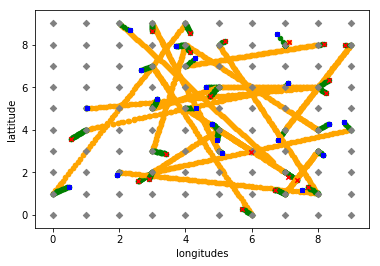

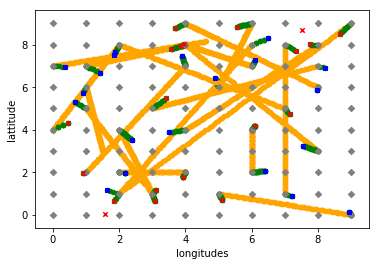

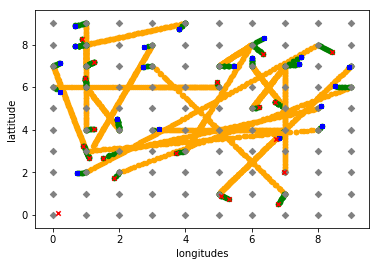

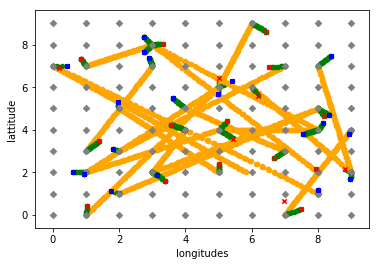

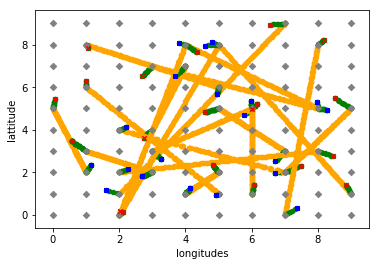

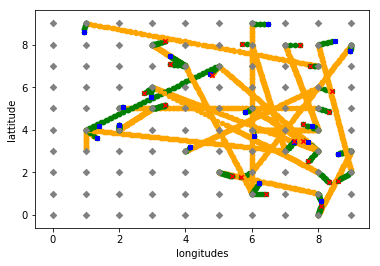

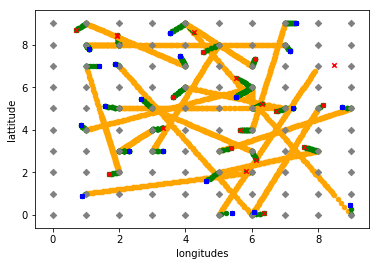

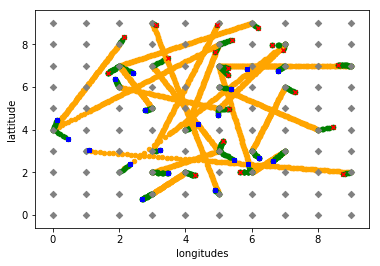

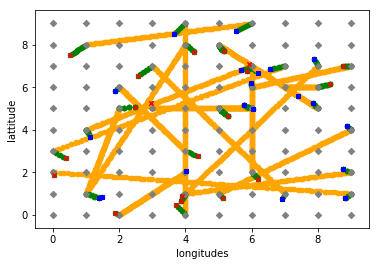

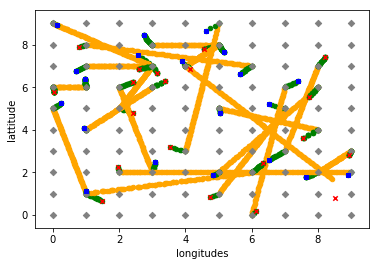

In [326]:
!rm cyclistes.csv
!rm stations.csv
!rm trajets.csv
for i in range(10):
    p = Prestataire(10,10)
    nb_cyclistes = 20
    v = Ville(nb_cyclistes,p)
    for i in range(150):
        v.reveil()
    v.draw_parcours()
Cycliste.cycliste_logger.write_to_disk()

In [329]:
import pandas as pd
df = pd.DataFrame([c.__dict__ for c in v.cyclistes])
df.to_csv("cyclistes_infos.csv")
df

,age,atout,atout2,destination,destination_finale,est_en_route,home,id,nb_pas,position,...,sexe,station_home,station_travail,sur_velo,trajet,travail,velo,ville,vitesse_a_pied,vitesse_a_velo
0,54,1.2,-0.074074,(lon:2.00 lat:5.00),(lon:2.41 lat:4.78),False,(lon:2.58 lat:7.49),201,4.789343,(lon:2.15 lat:5.30),...,H,"Station n° 55436 : (lon:3.00 lat:7.00), 5 born...","Station n° 55424 : (lon:2.00 lat:5.00), 30 bor...",True,(lon:2.18 lat:5.37) -> (lon:2.00 lat:5.00),(lon:2.41 lat:4.78),velo_717939 : perf = 0.61,<__main__.Ville object at 0x110bab908>,10.151720,6.961658
1,70,1.2,-0.285714,(lon:3.00 lat:7.00),(lon:3.16 lat:6.65),False,(lon:0.14 lat:8.94),202,3.816062,(lon:0.45 lat:8.70),...,H,"Station n° 55408 : (lon:0.00 lat:9.00), 15 bor...","Station n° 55436 : (lon:3.00 lat:7.00), 5 born...",True,(lon:0.37 lat:8.75) -> (lon:3.00 lat:7.00),(lon:3.16 lat:6.65),velo_717747 : perf = 0.61,<__main__.Ville object at 0x110bab908>,10.995388,8.866227
2,39,2.0,0.282051,(lon:7.00 lat:3.00),(lon:6.53 lat:2.59),False,(lon:6.53 lat:2.59),203,5.822807,(lon:7.49 lat:4.97),...,F,"Station n° 55472 : (lon:7.00 lat:3.00), 5 born...","Station n° 55486 : (lon:8.00 lat:7.00), 30 bor...",True,(lon:7.52 lat:5.09) -> (lon:7.00 lat:3.00),(lon:8.23 lat:7.42),velo_718837 : perf = 0.66,<__main__.Ville object at 0x110bab908>,5.582380,11.937934
3,21,2.0,1.380952,(lon:1.00 lat:7.00),(lon:0.69 lat:6.75),False,(lon:0.69 lat:6.75),204,2.000000,(lon:1.47 lat:7.00),...,F,"Station n° 55416 : (lon:1.00 lat:7.00), 5 born...","Station n° 55436 : (lon:3.00 lat:7.00), 5 born...",True,(lon:1.69 lat:7.00) -> (lon:1.00 lat:7.00),(lon:2.59 lat:6.87),velo_717823 : perf = 0.72,<__main__.Ville object at 0x110bab908>,9.552894,18.314509
4,33,1.2,0.515152,(lon:1.00 lat:4.00),(lon:0.94 lat:4.08),False,(lon:0.94 lat:4.08),205,2.000000,(lon:1.62 lat:4.62),...,H,"Station n° 55413 : (lon:1.00 lat:4.00), 15 bor...","Station n° 55435 : (lon:3.00 lat:6.00), 10 bor...",True,(lon:1.71 lat:4.71) -> (lon:1.00 lat:4.00),(lon:3.38 lat:6.28),velo_717808 : perf = 0.77,<__main__.Ville object at 0x110bab908>,9.663186,9.461923
5,68,1.2,-0.264706,(lon:1.00 lat:8.00),(lon:0.80 lat:7.89),False,(lon:5.65 lat:6.62),206,2.000000,(lon:4.81 lat:7.24),...,H,"Station n° 55466 : (lon:6.00 lat:7.00), 5 born...","Station n° 55417 : (lon:1.00 lat:8.00), 10 bor...",True,(lon:4.94 lat:7.21) -> (lon:1.00 lat:8.00),(lon:0.80 lat:7.89),velo_717825 : perf = 0.83,<__main__.Ville object at 0x110bab908>,4.241896,9.790048
6,17,1.2,1.941176,(lon:0.96 lat:6.39),(lon:0.96 lat:6.39),False,(lon:0.96 lat:6.39),207,3.612896,(lon:0.96 lat:6.39),...,H,"Station n° 55415 : (lon:1.00 lat:6.00), 10 bor...","Station n° 55405 : (lon:0.00 lat:6.00), 15 bor...",False,(lon:0.96 lat:6.33) -> (lon:0.96 lat:6.39),(lon:0.04 lat:5.76),False,<__main__.Ville object at 0x110bab908>,6.611169,16.874705
7,56,1.2,-0.107143,(lon:7.00 lat:5.00),(lon:6.51 lat:5.21),False,(lon:6.51 lat:5.21),208,2.000000,(lon:6.74 lat:4.47),...,H,"Station n° 55474 : (lon:7.00 lat:5.00), 30 bor...","Station n° 55450 : (lon:5.00 lat:1.00), 10 bor...",True,(lon:6.70 lat:4.40) -> (lon:7.00 lat:5.00),(lon:4.75 lat:0.83),velo_718636 : perf = 0.67,<__main__.Ville object at 0x110bab908>,6.404073,6.912948
8,16,2.0,2.125000,(lon:4.57 lat:7.81),(lon:4.57 lat:7.81),False,(lon:2.74 lat:8.43),209,3.119986,(lon:4.79 lat:7.91),...,F,"Station n° 55437 : (lon:3.00 lat:8.00), 20 bor...","Station n° 55457 : (lon:5.00 lat:8.00), 30 bor...",False,(lon:4.90 lat:7.95) -> (lon:4.57 lat:7.81),(lon:4.57 lat:7.81),False,<__main__.Ville object at 0x110bab908>,6.751557,14.723182
9,48,1.2,0.041667,(lon:6.00 lat:0.00),(lon:6.12 lat:0.16),False,(lon:7.40 lat:6.28),210,3.894634,(lon:6.28 lat:1.70),...,H,"Station n° 55475 : (lon:7.00 lat:6.00), 15 bor...","Station n° 55459 : (lon:6.00 lat:0.00), 5 born...",True,(lon:6.31 lat:1.86) -> (lon:6.00 lat:0.00),(lon:6.12 lat:0.16),velo_718640 : perf = 0.85,<__main__.Ville object at 0x110bab908>,6.385746,11.392263


1390

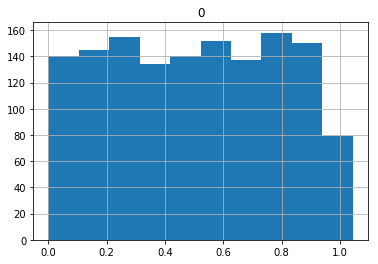

In [328]:
import pandas as pd
velo_des_stations  = [velo for station in v.prestataire.reseau for velo in station.velos]
velo_des_cyclistes = [c.velo for c in v.cyclistes]
velo_de_la_ville = set(velo_des_stations).union(set(velo_des_cyclistes))
performances = [v.performance for v in list(velo_de_la_ville) if v]
pd.DataFrame(performances).hist()
len(performances)